**Import required libraries**

In [1]:
!pip install pytorch-msssim
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
import os
import torch
import helper
import torch.nn as nn
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torchvision
from tqdm.notebook import tqdm
import torch.optim as optim
from google.colab import drive
from PIL import Image 

drive.mount('/content/drive')

data_path = './drive/MyDrive/images'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
#@title Utility 
class LinearFilter:
    def __init__(self, kernel):
        """
        kernel: torch.nn.Conv2D kernel
        """
    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        with torch.no_grad():
            return kernel(x)

class Left_Operator_ADMM:
    """
    Refer to paper "PNP methods for MRI" p. 108 eq.(12)
    """
    def __init__(self, LinearFilter, Adjoint_LinearFilter, sigma_2, eta):
        self.linear_filter = LinearFilter
        self.adj_linear_filter = Adjoint_LinearFilter
        self.sigma_2_over_eta = sigma_2/eta
    
    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        p = self.sigma_2_over_eta*x
        q = self.adj_linear_filter(self.linear_filter(x))
    
        return (p+q)

class Right_Operator_ADMM:
    """
    Refer to paper "PNP methods for MRI" p. 108 eq.(12)
    """
    def __init__(self, Adjoint_LinearFilter, sigma_2, eta, y):
        self.sigma_2_over_eta = sigma_2/eta
        self.Ahy =  Adjoint_LinearFilter(y)
    
    def __call__(self, z):
        return self.forward(z)

    def forward(self, z):
        return  self.Ahy + self.sigma_2_over_eta*z

class Left_Operator_HQS:
    """
    Refer to paper "PNP methods for MRI" p. 108 eq.(12)
    """
    def __init__(self, LinearFilter, Adjoint_LinearFilter, mu):
        self.linear_filter = LinearFilter
        self.adj_linear_filter = Adjoint_LinearFilter
        self.mu = mu
    
    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        p = self.mu*x
        q = self.adj_linear_filter(self.linear_filter(x))
    
        return (p+q)

class Right_Operator_HQS:
    """
    Refer to paper "PNP methods for MRI" p. 108 eq.(12)
    """
    def __init__(self, Adjoint_LinearFilter, mu, y):
        self.mu = mu
        self.Ahy =  Adjoint_LinearFilter(y)
    
    def __call__(self, z):
        return self.forward(z)

    def forward(self, z):
        return  self.Ahy + self.mu*z

class Denoiser:
    """
    Refer to paper "PNP methods for MRI" p. 108 eq.(12)
    """
    def __init__(self, DNN_Denoiser):
        self.dnn_denoiser = DNN_Denoiser.eval()
    
    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        with torch.no_grad():
            return self.dnn_denoiser(x)


def loss(x, y):
    l1 = nn.L1Loss()
    # l2 = nn.MSELoss()
    return (l1(x,y)*(1-ms_ssim(x,y,data_range=1.0, size_average=True, win_size=3, win_sigma=0.5)))
    # return (l1(x,y)*(1-ssim(x,y,data_range=1.0, size_average=True)))
def train(model, optimizer, sample):
    model.train()
    # criterion = nn.MSELoss() 
    criterion = loss
    optimizer.zero_grad()

    input = sample['input'].to(device)
    target = sample['target'].to(device) 
    
    pred = model(input)
    pred_loss = criterion(pred, target)
    
    pred_loss.backward()
       
    optimizer.step()

    return pred_loss.item()

def validate(model, sample):
    model.eval()

    criterion = nn.MSELoss()

    with torch.no_grad():
        input = sample['input'].to(device)
        target = sample['target'].to(device) 

        pred = model(input)
        pred_loss = criterion(pred, target)


    return pred_loss.item()

def Conv2d_gaussian_blur_kernel(filter_size, sigma):
    x = torch.arange(-(filter_size-1)/2, (filter_size+1)/2)
    k = torch.exp(-x**2/(2*sigma**2)).reshape(-1, 1)  
    k = k@k.T
    k /= torch.sum(k)
    c = torch.nn.Conv2d(3, 3, filter_size, padding = int((filter_size-1)/2), bias = False, groups=3).to(device).to(dtype)
    with torch.no_grad():
        c.weight.copy_(k)
    for param in c.parameters():
        param.requires_grad = False
    return c

def adjoint_Conv2d_gaussian_blur_kernel(filter_size, sigma):
    x = torch.arange(-(filter_size-1)/2, (filter_size+1)/2)
    k = torch.exp(-x**2/(2*sigma**2)).reshape(-1, 1)  
    k = k@k.T
    k /= torch.sum(k)
    c = torch.nn.ConvTranspose2d(3, 3, filter_size, padding = int((filter_size-1)/2), bias = False, groups=3).to(device).to(dtype)
    with torch.no_grad():
        c.weight.copy_(k)
    for param in c.parameters():
        param.requires_grad = False
    return c

def Conv2d_uniform_blur_kernel(filter_size):
    x = torch.arange(-(filter_size-1)/2, (filter_size+1)/2)
    k = torch.ones((filter_size, filter_size))
    k /= torch.sum(k)
    c = torch.nn.Conv2d(3, 3, filter_size, padding = int((filter_size-1)/2), bias = False, groups=3).to(device).to(dtype)
    with torch.no_grad():
        c.weight.copy_(k)
    for param in c.parameters():
        param.requires_grad = False
    return c

def adjoint_Conv2d_uniform_blur_kernel(filter_size):
    x = torch.arange(-(filter_size-1)/2, (filter_size+1)/2)
    k = torch.ones((filter_size, filter_size))
    k /= torch.sum(k)
    c = torch.nn.ConvTranspose2d(3, 3, filter_size, padding = int((filter_size-1)/2), bias = False, groups=3).to(device).to(dtype)
    with torch.no_grad():
        c.weight.copy_(k)
    for param in c.parameters():
        param.requires_grad = False
    return c

# Conjugate gradient method
def cg(A, b, x0, numit, tol):
    x = x0
    r = b-A(x)
    d = r
    for _ in range(numit):
        z = A(d)
        rr = torch.sum(r**2)
        alpha = rr/torch.sum(d*z)
        x += alpha*d
        r -= alpha*z
        if torch.norm(r) < tol:
            break
        beta = torch.sum(r**2)/rr
        d = r + beta*d        
    return x

# ADMM
def PnP_ADMM(Left_Operator, Right_Operator, Denoiser, x0, numit, num_cgit = 4, cg_tol = 1e-6):
    x = x0;
    u = torch.zeros_like(x)
    v = Denoiser(x+u)
    for _ in range(numit):
        b = Right_Operator(v-u)
        x = cg(Left_Operator, b, x, num_cgit, cg_tol)
        v = Denoiser(x+u)
        u += (x - v)
    
    return (x,v,u)

# HQS
def PnP_HQS(Left_Operator, Right_Operator, Denoiser, x0, numit, num_cgit = 4, cg_tol = 1e-6):
    x = x0;
    z = Denoiser(x)
    for i in range(numit):
        Left_Operator.mu *= 1
        Right_Operator.mu *= 1
        b = Right_Operator(z)
        x = cg(Left_Operator, b, x, num_cgit, cg_tol)
        z = Denoiser(x)

    return (x,z)

# Accelerated-PG RED
def PnP_apgRED(Left_Operator, Right_Operator, Denoiser, L, x0, numit, num_cgit = 4, cg_tol = 1e-6):
    x = x0
    v = torch.zeros_like(x)
    q = torch.tensor([1.]).to(device)
    for _ in range(numit):
        qk = q
        xk = x
        b = Right_Operator(v)
        x = cg(Left_Operator, b, x, num_cgit, cg_tol)
        q = (1 + torch.sqrt(1+4*qk**2))/2
        z = x + (qk-1)/q * (x-xk)
        v = 1/L*Denoiser(z)+(1-1/L)*z
    return (x,z,v)
    
# PSNR
def compute_psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return "Same Image"
    return (10 * torch.log10(torch.max(img1) / mse)).item()



# Load test image 
def pnp_results(image_name, plot_gt = False):
    image_path = './drive/MyDrive/images/{}.png'.format(image_name)
    img = Image.open(image_path)
    img = torchvision.transforms.ToTensor()(img)
    gt = img.unsqueeze(0).to(device).to(dtype)
    # Downsampling

    pr = 0.2
    P = torch.empty(gt.shape[2], gt.shape[3]).uniform_(pr, pr)
    P = torch.bernoulli(P).to(device).to(torch.bool) # Mask

    # Linear operator
    F =  torchvision.transforms.GaussianBlur(2*3*1.6,(1.6,1.6))
    def A(x): # Operator A (as in y = Ax + noise)
        y = torch.zeros_like(x)
        y[:,:,P] = F(x)[:,:,P]
        return y
    def Ah(y): # Operator A (as in y = Ax + noise)
        x = torch.zeros_like(y)
        x[:,:,P] = y[:,:,P]
        return F(x)

    # noise level (image range [0, 1])
    noise = 0.01
    print('white noise std: ', noise)
    # get measurements y = Ax + noise
    y = A(gt)+noise*torch.randn_like(gt).to(device)

    # Hyperparameter
    eta = 1
    sigma_2 = 0.1*eta
    left_operator = Left_Operator_ADMM(A, Ah, sigma_2, eta)
    right_operator = Right_Operator_ADMM(Ah, sigma_2, eta, y)

    # Plug in Denoiser
    denoiser = Denoiser(model.to(dtype))

    # Play algorithm
    x0 = Ah(y) # init
    sol = PnP_ADMM(left_operator, right_operator, denoiser, x0, numit=100, num_cgit=4, cg_tol=1e-6)
    xpnp = sol[1]

    # PSNR
    print('PSNR: ', round(compute_psnr(gt, xpnp),2))
    print('SSIM: ', round(ssim(gt,xpnp,data_range=1.0).item(),2))
    # Plot
    if plot_gt == True:
        fig, ax = plt.subplots(1, 2, figsize=(10, 10))
        ax[0].imshow(y.detach().cpu().squeeze().permute(1,2,0))
        if image_name == "parrot":
          ax[1].imshow(y[0][:, 200:250, 190:240].detach().cpu().squeeze().permute(1,2,0))
        elif image_name == "monarch":
          ax[1].imshow(y[0][:, 200:250, 325:375].detach().cpu().squeeze().permute(1,2,0))
        elif image_name == "lena":
          ax[1].imshow(y[0][:, 250:300, 240:290].detach().cpu().squeeze().permute(1,2,0))
        for axs in ax:
            axs.set_xticks([])
            axs.set_yticks([])

        fig, ax = plt.subplots(1, 2, figsize=(10, 10))
        ax[0].imshow(xpnp.detach().cpu().squeeze().permute(1,2,0))
        if image_name == "parrot":
          ax[1].imshow(xpnp[0][:, 200:250, 190:240].detach().cpu().squeeze().permute(1,2,0))
        elif image_name == "monarch":
          ax[1].imshow(xpnp[0][:, 200:250, 325:375].detach().cpu().squeeze().permute(1,2,0))
        elif image_name == "lena":
          ax[1].imshow(xpnp[0][:, 250:300, 240:290].detach().cpu().squeeze().permute(1,2,0))

        for axs in ax:
            axs.set_xticks([])
            axs.set_yticks([])
    else:
        fig, ax = plt.subplots(1, 2, figsize=(10, 10))
        ax[0].imshow(xpnp.detach().cpu().squeeze().permute(1,2,0))
        if image_name == "parrot":
          ax[1].imshow(xpnp[0][:, 200:250, 190:240].detach().cpu().squeeze().permute(1,2,0))
        elif image_name == "monarch":
          ax[1].imshow(xpnp[0][:, 200:250, 325:375].detach().cpu().squeeze().permute(1,2,0))
        elif image_name == "lena":
          ax[1].imshow(xpnp[0][:, 250:300, 240:290].detach().cpu().squeeze().permute(1,2,0))

        for axs in ax:
            axs.set_xticks([])
            axs.set_yticks([])



def pnp_results_lena(image_name, plot_gt = False):
    image_path = './drive/MyDrive/images/{}.png'.format(image_name)
    img = Image.open(image_path)
    img = torchvision.transforms.ToTensor()(img)
    gt = img.unsqueeze(0).to(device).to(dtype)
    # Downsampling
    pr = 0.1
    P = torch.empty(gt.shape[2], gt.shape[3]).uniform_(pr, pr)
    P = torch.bernoulli(P).to(device).to(torch.bool) # Mask

    # Linear operator
    F =  torchvision.transforms.GaussianBlur(2*3*1.6,(1.6,1.6))
    def A(x): # Operator A (as in y = Ax + noise)
        y = torch.zeros_like(x)
        y[:,:,P] = F(x)[:,:,P]
        return y
    def Ah(y): # Operator A (as in y = Ax + noise)
        x = torch.zeros_like(y)
        x[:,:,P] = y[:,:,P]
        return F(x)

    # noise level (image range [0, 1])
    noise = 0.01
    print('white noise std: ', noise)
    # get measurements y = Ax + noise
    y = A(gt)+noise*torch.randn_like(gt).to(device)

    # Hyperparameter
    eta = 1
    sigma_2 = 0.1*eta
    left_operator = Left_Operator_ADMM(A, Ah, sigma_2, eta)
    right_operator = Right_Operator_ADMM(Ah, sigma_2, eta, y)

    # Plug in Denoiser
    denoiser = Denoiser(model.to(dtype))

    # Play algorithm
    x0 = Ah(y) # init
    sol = PnP_ADMM(left_operator, right_operator, denoiser, x0, numit=100, num_cgit=4, cg_tol=1e-6)
    xpnp = sol[1]

    # PSNR
    print('PSNR: ', round(compute_psnr(gt, xpnp),3))
    print('SSIM: ', round(ssim(gt,xpnp,data_range=1.0).item(),3))
    # Plot
    if plot_gt == True:
        fig, ax = plt.subplots(1, 2, figsize=(10, 10))
        ax[0].imshow(y.detach().cpu().squeeze().permute(1,2,0))
        ax[1].imshow(xpnp.detach().cpu().squeeze().permute(1,2,0))

        for axs in ax:
            axs.set_xticks([])
            axs.set_yticks([])

    else:
        plt.imshow(xpnp.detach().cpu().squeeze().permute(1,2,0))

# Utilities

import math
# PSNR
def compute_psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return "Same Image"
    return (10 * torch.log10(torch.max(img1) / mse)).item()
# Mean
def mean(input_list):
  num = len(input_list)
  mean = (sum(input_list))/(num)
  return mean
# Standard Deviation
def std(input_list):
  num = len(input_list)
  mean = sum(input_list)/(num)
  deviations = [(x - mean) ** 2 for x in input_list]
  variance = sum(deviations) / (num-1)
  std = math.sqrt(variance)
  return std

def average_stats(is_Gaussian = False):
    
    if is_Gaussian == True:
        noise = 0.05
    else:
        noise = 0.2
    concatenated_patches_list
    model.eval()

    psnr_values = []
    ssim_values = []

    for inp in concatenated_patches_list:
        if is_Gaussian == True:        
            noisy_inp = inp + noise*torch.randn_like(inp)
        else: 
            noisy_inp = inp + noise*torch.rand_like(inp) - noise/2   
        noisy_inp = noisy_inp.to(device)
        inp = inp.to(device)
        with torch.no_grad():
            model_out = model(noisy_inp)
        psnr_values.append(compute_psnr(inp, model_out))
        ssim_values.append(ssim(inp, model_out, data_range=1.0).item())

    average_psnr = mean(psnr_values)
    average_ssim = mean(ssim_values)

    std_psnr = std(psnr_values)
    std_ssim = std(ssim_values)

    print("The average PSNR value is: {}".format(round(average_psnr,3)))
    print("The average SSIM value is: {}".format(round(average_ssim,3)))
    print("The average standard deviation of the PSNR value is: {}".format(std_psnr))
    print("The average standard deviation of the SSIM value is: {}".format(std_ssim))



In [3]:
test_images = os.path.join(data_path, 'Test_Patches_Denoiser_Evaluation')
img_list = sorted(os.listdir(test_images))

tensor_transform = torchvision.transforms.ToTensor()
concatenated_patches_list = []
img_path_label = list()
for fp in img_list:
   full_fp = os.path.join(test_images, fp)
   img_path_label.append(full_fp)

for im in img_path_label:
    img = Image.open(im)
    input = tensor_transform(img).unsqueeze(0)
    concatenated_patches_list.append(input)

In [4]:
#@title Device and data type
device = 'cuda'
dtype = torch.float32

**Define model classes for CNN-based denoisers and U-net based denoisers**

In [5]:
# Model class for CNN based denoiser trained on MSE

class Model(nn.Module):
    def __init__(self, dim):
        super(Model, self).__init__()

        self.num_feature_maps = 64
        self.filter_size = 3
        self.in_conv2d = nn.Conv2d(dim, self.num_feature_maps, self.filter_size, padding = 1)

        self.hid1 = nn.Conv2d(self.num_feature_maps, self.num_feature_maps, self.filter_size, dilation = 2, padding = 2)
        self.hid2 = nn.Conv2d(self.num_feature_maps, self.num_feature_maps, self.filter_size, dilation = 3, padding = 3)
        self.hid3 = nn.Conv2d(self.num_feature_maps, self.num_feature_maps, self.filter_size, dilation = 4, padding = 4)
        self.hid4 = nn.Conv2d(self.num_feature_maps, self.num_feature_maps, self.filter_size, dilation = 3, padding = 3)
        self.hid5 = nn.Conv2d(self.num_feature_maps, self.num_feature_maps, self.filter_size, dilation = 2, padding = 2)


        self.out_conv2d = nn.Conv2d(self.num_feature_maps, dim, self.filter_size, padding = 1)
        
        self.bn2d = nn.BatchNorm2d(64)
        self.dropout = nn.Dropout(p=0.0)
        self.h = nn.GELU()
        # self.h = nn.ReLU()

        
    def forward(self, img):
        out = self.dropout(self.h(self.in_conv2d(img)))

        out = self.dropout(self.h((self.hid1(out))))
        out = self.dropout(self.h((self.hid2(out))))
        out = self.dropout(self.h((self.hid3(out))))
        out = self.dropout(self.h((self.hid4(out))))
        out = self.dropout(self.h((self.hid5(out))))

        
        out = img-self.out_conv2d(out)

        return out

**Load CNN Denoiser MSE** 


In [6]:
checkpoint = torch.load('./drive/MyDrive/All_Models/denoiser_rgb_1.pth')
model = checkpoint['model']
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)

white noise std:  0.01


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR:  29.56
SSIM:  0.76


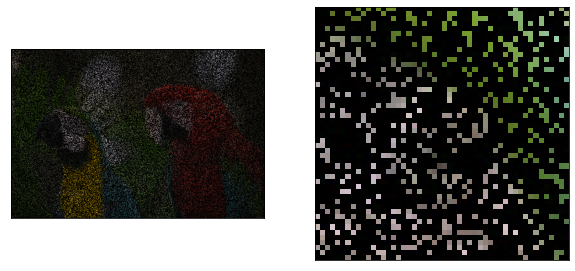

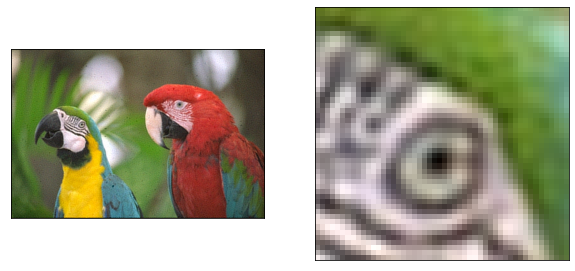

In [7]:
pnp_results('parrot', plot_gt = True)

In [8]:
average_stats(is_Gaussian=True)

The average PSNR value is: 29.291
The average SSIM value is: 0.811
The average standard deviation of the PSNR value is: 1.5802282949401454
The average standard deviation of the SSIM value is: 0.11955623550359493


**Load CNN_Good_Denoiser**

In [9]:
checkpoint = torch.load('./drive/MyDrive/All_Models/denoiser_rgb_4.pth')
model = checkpoint['model']
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)

white noise std:  0.01


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR:  29.75
SSIM:  0.87


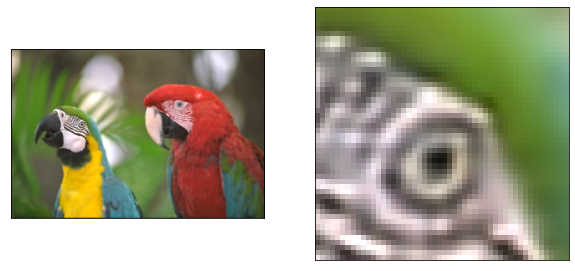

In [10]:
pnp_results('parrot')

white noise std:  0.01


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR:  25.117
SSIM:  0.697


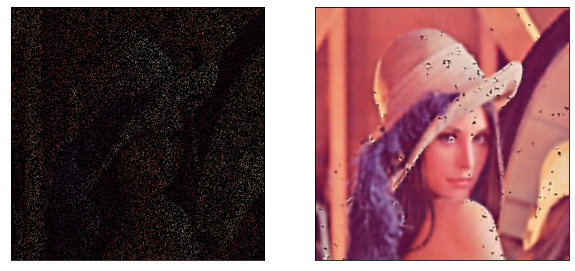

In [11]:
pnp_results_lena('lena', plot_gt = True)

In [12]:
average_stats(is_Gaussian=True)

The average PSNR value is: 32.436
The average SSIM value is: 0.923
The average standard deviation of the PSNR value is: 2.6229603086221993
The average standard deviation of the SSIM value is: 0.03340654006226189


**Load CNN_Bad_Denoiser**

In [13]:
checkpoint = torch.load('./drive/MyDrive/All_Models/denoiser_rgb_3.pth')
model = checkpoint['model']
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)

white noise std:  0.01


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR:  30.44
SSIM:  0.84


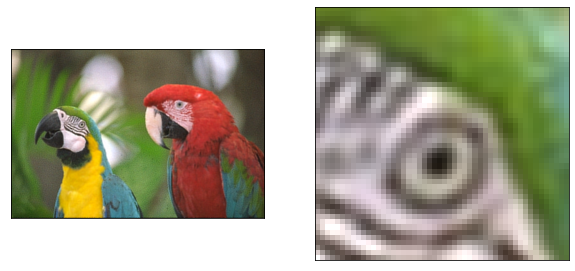

In [14]:
pnp_results('parrot')

white noise std:  0.01


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR:  28.124
SSIM:  0.756


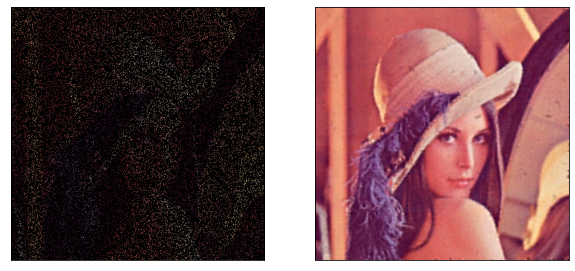

In [15]:
pnp_results_lena('lena', plot_gt = True)

In [16]:
average_stats(is_Gaussian=True)

The average PSNR value is: 30.339
The average SSIM value is: 0.865
The average standard deviation of the PSNR value is: 1.735837754326387
The average standard deviation of the SSIM value is: 0.07161827977622792


________________________________________________________________________________

________________________________________________________________________________

In [17]:
#@title U-net model class

# Model class for U-net based denoiser
import torch.nn.functional as FF
class Model(nn.Module):
    def __init__(self, dim):
      super(Model, self).__init__()




      def double_conv(in_c, out_c):
        conv =nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size =3, padding =1),
        nn.ReLU(inplace = True),
        nn.Conv2d(out_c, out_c, kernel_size =3, padding  =1),
        nn.ReLU(inplace = True)
        )
        return conv
      self.max_pool_2x2 = nn.MaxPool2d(kernel_size =2, stride =2)
      self.down_conv_1 = double_conv(3,64)
      self.down_conv_2 = double_conv(64,128)
      self.down_conv_3 = double_conv(128,256)
      self.down_conv_4 = double_conv(256,512)
      self.down_conv_5 = double_conv(512,1024)

      self.up_trans_1 = nn.ConvTranspose2d(in_channels = 1024, out_channels = 512, kernel_size = 2, stride =2)
      self.up_conv_1 = double_conv(1024,512)

      self.up_trans_2 = nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size = 2, stride =2)
      self.up_conv_2 = double_conv(512,256)

      self.up_trans_3 = nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size = 2, stride =2)
      self.up_conv_3 = double_conv(256,128)

      self.up_trans_4 = nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = 2, stride =2)
      self.up_conv_4 = double_conv(128,64)


      self.out = nn.Conv2d(in_channels = 64, out_channels = 3, kernel_size = 1)

        
    def forward(self, img):
      def paddington(goaltensor, tensor):
        
            source_pad = FF.pad(tensor, pad=(0, goaltensor.shape[3] - tensor.shape[3],0, goaltensor.shape[2] - tensor.shape[2]))
            return source_pad


        

      x1 = self.down_conv_1(img) #

      x2 =  self.max_pool_2x2(x1)
      x3 = self.down_conv_2(x2) #
      x4 =  self.max_pool_2x2(x3)
      x5 = self.down_conv_3(x4)#
      x6 =  self.max_pool_2x2(x5)
      x7 = self.down_conv_4(x6) #
      x8 =  self.max_pool_2x2(x7)
      x9 = self.down_conv_5(x8) #
     
      x = self.up_trans_1(x9).to(device)

      y = paddington(x7,x).to(device)
      x = self.up_conv_1(torch.cat([y,x7],1)).to(device)

      x = self.up_trans_2(x).to(device)
      y = paddington(x5,x).to(device)
      x = self.up_conv_2(torch.cat([y,x5],1))
    
      x = self.up_trans_3(x).to(device)
      y = paddington(x3,x).to(device)
      x = self.up_conv_3(torch.cat([y,x3],1))

      x = self.up_trans_4(x).to(device)
      y = paddington(x1,x).to(device)
      #print(x.shape)
      #print(x7.shape)
      x = self.up_conv_4(torch.cat([y,x1],1))




      #print(x.shape)
      x = self.out(x)
      return x



**Load U-net Denoiser MSE** 

In [31]:
checkpoint = torch.load('./drive/MyDrive/All_Models/denoiser_rgb_Unet_MSE.pth')
model = checkpoint['model']
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)

white noise std:  0.01


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR:  28.99
SSIM:  0.9


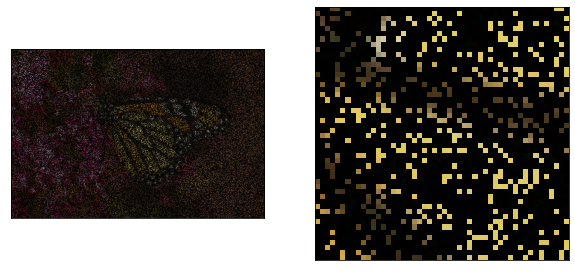

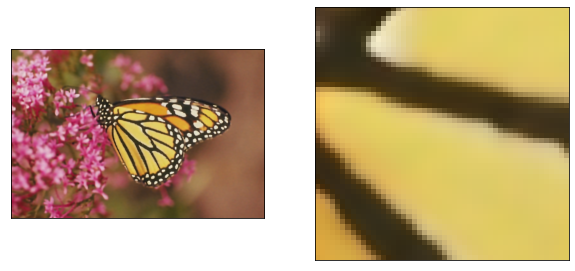

In [32]:
pnp_results('monarch', plot_gt = True)

In [20]:
average_stats()

The average PSNR value is: 32.276
The average SSIM value is: 0.915
The average standard deviation of the PSNR value is: 2.9020880553480057
The average standard deviation of the SSIM value is: 0.03963796813823896


**Load U-net Good Denoiser** 

In [33]:
checkpoint = torch.load('./drive/MyDrive/All_Models/denoiser_rgb_Unet_L1_good.pth')
model = checkpoint['model']
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)

white noise std:  0.01


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR:  29.01
SSIM:  0.9


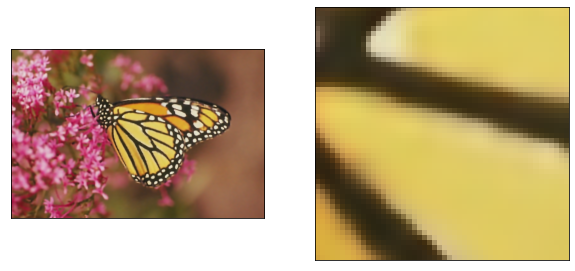

In [34]:
pnp_results('monarch')

white noise std:  0.01


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR:  27.905
SSIM:  0.744


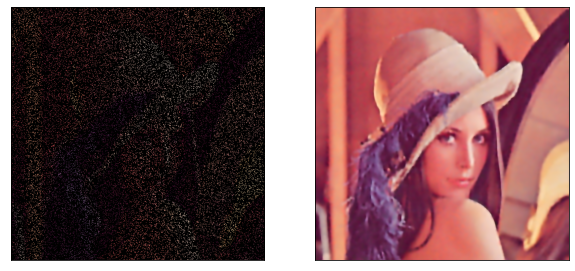

In [23]:
pnp_results_lena('lena', plot_gt = True)

In [24]:
average_stats()

The average PSNR value is: 32.547
The average SSIM value is: 0.919
The average standard deviation of the PSNR value is: 3.3823907026684075
The average standard deviation of the SSIM value is: 0.03938244579589761


**Load U-net Bad Denoiser** 

In [25]:
checkpoint = torch.load('./drive/MyDrive/All_Models/denoiser_rgb_Unet_L1_bad.pth')
model = checkpoint['model']
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)

white noise std:  0.01


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR:  28.51
SSIM:  0.89


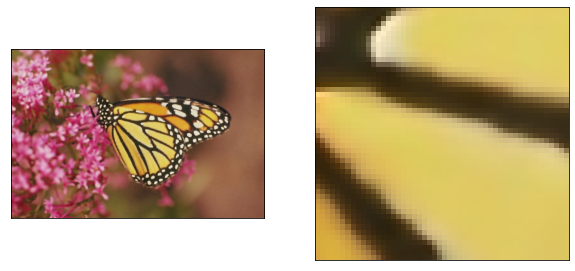

In [26]:
pnp_results('monarch')

white noise std:  0.01


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR:  27.074
SSIM:  0.736


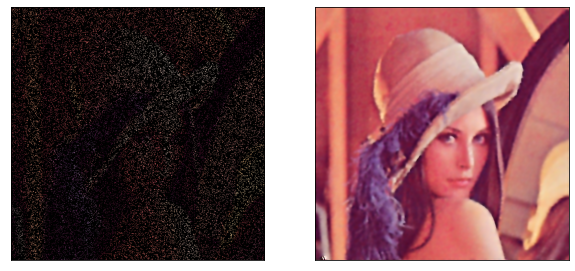

In [27]:
pnp_results_lena('lena', plot_gt = True)

In [29]:
average_stats()

The average PSNR value is: 30.53
The average SSIM value is: 0.883
The average standard deviation of the PSNR value is: 2.6510110100536344
The average standard deviation of the SSIM value is: 0.042374383130799824
